# Lab 13: Reinforcement Learning (RL)

**I bring lab 13 and 14 of RL in RTML class (Up to DQN, remove self-environment creation). Please design exercise at below :-)**

Today we'll have a gentle introduction to reinforcement learning.
The material in today's lab comes from these references:

 - Pytorch 1.x Reinforcement Learning Cookbook (Packtpub)
 - Hands-On Reinforcement Learning for Games (Packtpub)
 - https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html
 - Reinforcement Learning: An Introduction (Sutton et al.)
 - https://github.com/werner-duvaud/muzero-general (simulator code)


## Reinforcement learning

Reinforcement Learning (RL) is a machine learning technique that enables an agent to learn in an interactive environment by trial and error using feedback on its actions and experiences.
RL uses rewards and punishment as signals for "good" and "bad" behavior.

Generally, at each step, the agent outputs an action, which is input to the environment. The environment evolves according to its dynamics, the agent observes the new state of the environment
and (optionally) a reward, and the process continues until hopefully the agent learns what behavior maximizes its reward.

<img src="img/RL.jpg" title="Introduction" style="width: 600px;" />


## Markov decision process (MDP)

Markov decision process (MDP) is a discrete-time stochastic control process.
It provides a mathematical framework for modeling decision making in situations where outcomes are partly random and partly under the control of a decision maker.
MDPs are useful for studying optimization problems solved via dynamic programming.
They are used in many disciplines, including robotics, automatic control, economics and manufacturing.

The MDP model is based on the idea of an environment that evolves as a Markov chain.

### Markov chain

A Markov chain is a model of the dynamics of a discrete time system that obeys the (first order) "Markov property," meaning that the state $s^{t+1}$ at time
$t+1$ is conditionally independent of the state at times $0, \ldots, t-1$ given the state at time $t$, i.e.,

$$ p(s^{t+1} \mid s^t, s^{t-1}, \ldots, s^0) = p(s^{t+1} \mid s^t). $$

Informally, we might say that the current state is all you need to know to predict the next state.

A Markov chain is defined by a set of possible states $S={s_0, s_1, \ldots, s_n}$ and a transition matrix $T(s,s')$ containing the propbabilities of state $s$ (current state) transitioning to state $s'$ (next state).

Here is a visualization of a simple Markov chain:

<img src="img/RL_markov.png" title="Markov chain" style="width: 600px;" />

You might be interested in [this Markov chain simulator](https://setosa.io/ev/markov-chains/) and the [full screen diagram](https://setosa.io/markov/index.html).

Now, the dynamics of the environment in a MDP are slightly different from that of a simple Markov chain. We have to consider how the agent's
actions affect the system's dynamics. At each time step, rather than just
transitioning randomly to the next state, we add the agent's action as an external input or disturbance $a \in A$, so (assuming a small number of discrete
states and actions) the transition probabilities become a 3D tensor of size $|S|\times |A|\times |S|$
mapping each state/action pair to a probability distribution over the states.

### A simple MDP

Assume we have **Three states** (**A**, **B**, **C**), the Markov chain is:

<img src="img/MarkovChain.PNG" title="Markov chain example" style="width: 400px;" />

The transition matrix is:

$$
T =
\begin{bmatrix}
0.3 & 0.5 & 0.2 \\ 
0.8 & 0.1 & 0.1 \\
0.1 & 0.3 & 0.6
\end{bmatrix}
$$

Each row means current state, and each column means the next state to go. If you consider $0.5$ in the matrix (row 0, and column 1), you can say that "now you are in state **A** and the possible to go to next state of **B** is 0.5"


In [2]:
import torch

T = torch.tensor([[0.3, 0.5, 0.2],
                  [0.8, 0.1, 0.1],
                  [0.1, 0.3, 0.6]])

# show the matrix
print(T)

tensor([[0.3000, 0.5000, 0.2000],
        [0.8000, 0.1000, 0.1000],
        [0.1000, 0.3000, 0.6000]])


#### Probability after k steps

The probability after $k$ steps equation is:
$$ T_n = T^n $$

Thus, if we want to find the T state at step 2, 5, 10, 20, we can do as:

In [3]:
T_2 = torch.matrix_power(T,2)
print('state transition at k=2:', T_2)
T_5 = torch.matrix_power(T,5)
print('state transition at k=5:', T_5)
T_10 = torch.matrix_power(T,10)
print('state transition at k=10:', T_10)
T_20 = torch.matrix_power(T,20)
print('state transition at k=20:', T_20)

state transition at k=2: tensor([[0.5100, 0.2600, 0.2300],
        [0.3300, 0.4400, 0.2300],
        [0.3300, 0.2600, 0.4100]])
state transition at k=5: tensor([[0.3991, 0.3230, 0.2779],
        [0.4153, 0.3100, 0.2746],
        [0.3926, 0.3165, 0.2908]])
state transition at k=10: tensor([[0.4026, 0.3170, 0.2804],
        [0.4024, 0.3172, 0.2804],
        [0.4024, 0.3170, 0.2806]])
state transition at k=20: tensor([[0.4024, 0.3171, 0.2805],
        [0.4024, 0.3171, 0.2805],
        [0.4024, 0.3171, 0.2805]])


The state transition after step 10 to 20 steps are going to converges. This means that, no matter what state the process is in, it has the same probability of transitioning to A (40.24%), B (31.71%), and C (28.05%).

### Initial Distribution

Assume we have the initial distribution of three state is:

$$
V=
\begin{bmatrix}
0.2 & 0.5 & 0.3
\end{bmatrix}
$$

The initial distribution means you can go to any states at the first time, but it depends on the probability. In this matrix, we can say that there are possible to go to state A more than other states.

In [4]:
V_0 = torch.tensor([[0.2, 0.5, 0.3]])

print(V_0)

tensor([[0.2000, 0.5000, 0.3000]])


Try to calculate the state distribution after state 1, 2, 5, 10, and 20

In [5]:
V_1 = torch.mm(V_0, T)
print("Distribution of states after 1 step:\n{}\n".format(V_1))
V_2 = torch.mm(V_0, T_2)
print("Distribution of states after 2 step:\n{}\n".format(V_2))
V_5 = torch.mm(V_0, T_5)
print("Distribution of states after 5 step:\n{}\n".format(V_5))
V_10 = torch.mm(V_0, T_10)
print("Distribution of states after 10 step:\n{}\n".format(V_10))
V_20 = torch.mm(V_0, T_20)
print("Distribution of states after 20 step:\n{}\n".format(V_20))

Distribution of states after 1 step:
tensor([[0.4900, 0.2400, 0.2700]])

Distribution of states after 2 step:
tensor([[0.3660, 0.3500, 0.2840]])

Distribution of states after 5 step:
tensor([[0.4053, 0.3146, 0.2801]])

Distribution of states after 10 step:
tensor([[0.4024, 0.3171, 0.2805]])

Distribution of states after 20 step:
tensor([[0.4024, 0.3171, 0.2805]])



We can see that, after 10 steps, the state distribution converges. The probability of being in A (40.24%), B (31.71%) and the probability of being in s1 (28.05%) remain unchanged in the long run.

Starting with $[0.2,0.5,0.3]$, the state distribution after one iteration becomes $[0.4024, 0.3171, 0.2805]$. Details of its calculation are illustrated in the following diagram:

<img src="img/MarkovDistributionChart.png" title="Markov chain example" style="width: 600px;" />

### Come back to MDP

MDP is slightly different from a simple Markov chain because MDP has to consider agent's actions which affect to the system's dynamics.
Thus, not only probability of transition of nextstate, but also agent's action need to be calculate. We assign $A$ as all possible actions and $a$ as the action which agent selects (at this situation, $a$ must be in $A$ or $a \in A$.

The transition probabilities become a **3D tensor** of size $|S|\times |A|\times |S|$
mapping each state/action pair to a probability distribution over the states.

### A simple MDP

Suppose we have **three states (s0, s1, s2) and two actions (a0, a1)** and that the state/action transition tensor is as follows:

$$T=
\begin{cases}
 &
\begin{bmatrix}
0.8 & 0.1 & 0.1 \\ 
0.1 & 0.6 & 0.3
\end{bmatrix} \\ 
 & 
\begin{bmatrix}
0.7 & 0.2 & 0.1 \\ 
0.1 & 0.8 & 0.1
\end{bmatrix} \\  
 & 
\begin{bmatrix}
0.6 & 0.2 & 0.2 \\ 
0.1 & 0.4 & 0.5
\end{bmatrix}
\end{cases}
$$

The first matrix block is mean current state $s0$, second block is $s1$, and the third block is $s2$.

Consider into the matrix block, the rows of matrix block mean actions (a0 is 1st row, and a1 is 2nd row). And the columns of matix block is the same as Markov Chain: next state $s'$

In [6]:
# State transition function
T = torch.tensor([[[0.8, 0.1, 0.1],
                   [0.1, 0.6, 0.3]],
                  [[0.7, 0.2, 0.1],
                   [0.1, 0.8, 0.1]],
                  [[0.6, 0.2, 0.2],
                   [0.1, 0.4, 0.5]]])

# show the matrix
print(T)

tensor([[[0.8000, 0.1000, 0.1000],
         [0.1000, 0.6000, 0.3000]],

        [[0.7000, 0.2000, 0.1000],
         [0.1000, 0.8000, 0.1000]],

        [[0.6000, 0.2000, 0.2000],
         [0.1000, 0.4000, 0.5000]]])


Assume we want to observe at state 2, and see the probability to change to state 1 with playing action 0, we can write in code with

In [7]:
T[2,0,1]

tensor(0.2000)

To complete our simple MDP, we need a *reward function* $R$ and a *discount factor* $\gamma$.

**reward function $R$** is a set of rewards that depend on the state and the action taken.

**discount factor $\gamma$** is how important future rewards are to the current state. Discount factor is a value between 0 and 1. A reward $R$ that occurs $n$ steps in the future from the current state, is multiplied by $\gamma^n$ to describe its importance to the current state (Thus, current reward is $\gamma^tR$, where $t$ is a number step.

Suppose $R = [ -1, 0.1, 0.9 ]$ and $\gamma = 0.5$. Let's define our MDP in Python with PyTorch tensors:

In [8]:
# Reward function
R = torch.tensor([-1.,0.1,0.9])

# Discount factor
gamma = 0.5

### The agent's goal

Once the MDP is defined, the agent's goal is to **maximize its expected reward**.

If we start in state $s^0$ and perform a series of actions $a^0, a^1, \ldots a^{T-1}$ placing us in state $s^1, s^2, \ldots s^T$, we obtain the total reward $R_F$

$$R_F=\sum_{t=0}^T \gamma^{t} R(s^t)$$

The agent's goal is to behave so as to maximize the expected total reward. To do so,
it should come up with a policy $\pi : S \times A \rightarrow \mathbb{R}$ giving a probability distribution
over actions that can be executed in each state, then when in state $s$, sample action $a$ according to that
distribution $\pi(s,\cdot)$, and repeat.

Now the agent's goal can be clearly specified as finding an optimal policy

$$ \pi^* = \textrm{argmax}_\pi \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1})}\left[ \sum_{t=0}^T \gamma^{t} R(s^t) \right]$$

Under a particular policy $\pi$, then, the *value* of state $s$ is the expected reward we obtain by following $\pi$ from state $s$:

$$ V^\pi(s) = \mathbb{E}_{a^t \sim \pi(s^t), s^{t} \sim T(s^{t-1},a^{t-1}) \mid s^0=s}\left[ R(s) + \sum_{t=1}^T \gamma^{t} R(s^t) \right]$$

The value function clearly obeys the *Bellman equations*

$$ V^\pi(s) = R(s) + \gamma \sum_{s',a'} \pi(s,a') T(s,a',s') V^\pi(s'). $$ 

#### Too difficult?

OK, lets see the easier version of equation

The equation of V relate at time t is:

$$V_{t+1}=R+\gamma * T * V_t$$

When the value converges, which mean $V_{t+1}=V_t$, so we can derive the value $V$ as:

$$
V=R+\gamma * T * V \\
V = (I-\gamma * T)^{-1} * R.
$$

The function can be writed as:

In [9]:
def cal_value_matrix_inversion(gamma, trans_matrix, rewards):
    inv = torch.inverse(torch.eye(rewards.shape[0]) - gamma * trans_matrix)
    V = torch.mm(inv, rewards.reshape(-1, 1))
    return V

Asume that we select action $a_0$ in all curcumstances.

In [10]:
action = 0

Find transition matrix:

In [11]:
trans_matrix = T[:, action]

print(trans_matrix)

tensor([[0.8000, 0.1000, 0.1000],
        [0.7000, 0.2000, 0.1000],
        [0.6000, 0.2000, 0.2000]])


Calculate value from the bellman equation above:

In [12]:
V = cal_value_matrix_inversion(gamma, trans_matrix, R)

print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([[-1.6781],
        [-0.5202],
        [ 0.3828]])


### Policy evaluation

To determine how good a particular policy is, we use policy evaluation.
Policy evaluation is an iterative algorithm. It starts with arbitrary values for each state
and then iteratively updates the values based on the Bellman equations until the values converge. Assume $\pi$ is the value of a policy, the update equation is:

$$ V(s) = \sum_a \pi(s,a) \left[ R(s,a) + \gamma \sum_{s'} T(s,a',s') V(s') \right] $$ 

$\pi(s,a)$: the probability of taking action $a$ in stat $s$ under policy $\pi$
$R(s,a)$: the reward received in state $s$ by taking action $a$

You can see this algorithm's pseudocode in Sutton's book on page 75.

Because Policy evaluation is a loop processing, you need to stop by conditions. There are 2 ways to terminate the iterative updating process.
- Fix number of iterations
- Set some specific threshold and terminating the process when the values of all states change to lower than the threshold.

Here we compute the value of the three states in our MDP assuming the agent always peforms the first action. The function process are:

1. Initializes the policy values as all zeros.
2. Updates the values based on the Bellman expectation equation.
3. Computes the maximal change of the values across all states.
4. If the maximal change is greater than the threshold, it keeps updating the values. Otherwise, it terminates the evaluation process and returns the latest values.

In [13]:
def policy_evaluation(policy, trans_matrix, rewards, gamma, threshold):
    """
    Perform policy evaluation
    @param policy: policy matrix containing actions and their 
                            probability in each state
    @param trans_matrix: transformation matrix
    @param rewards: rewards for each state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values 
                           for all states are less than the threshold
    @return: values of the given policy for all possible states
    """
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    V_his = [V]
    i = 0
    while True:
        V_temp = torch.zeros(n_state)
        i += 1
        for state, actions in enumerate(policy):
            for action, action_prob in enumerate(actions):
                V_temp[state] += action_prob * (R[state] + gamma * torch.dot(trans_matrix[state, action], V))
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        V_his.append(V)
        if max_delta <= threshold:
            break
    return V, V_his

Define the threshold used to determine when to stop the evaluation process and the optimal policy where action a0 is chosen under all circumstances:

In [14]:
threshold = 0.0001

policy_optimal = torch.tensor([[1.0, 0.0],
                               [1.0, 0.0],
                               [1.0, 0.0]])

Using the policy_evaluation function to find the optimal policy:

In [15]:
V, V_his = policy_evaluation(policy_optimal, T, R, gamma, threshold)

print("The value function under the optimal policy is:\n{}".format(V))

The value function under the optimal policy is:
tensor([-1.6780, -0.5201,  0.3829])


Plot the resulting history of values:

In [16]:
import matplotlib.pyplot as plt

def plot_history(V_history, gamma):
    s = []
    text = []
    for i in range(len(V_history[0])):
        s_x, = plt.plot([v[i] for v in V_history])
        s.append(s_x)
        text.append('State s' + str(i))

    plt.title('Optimal policy with gamma = {}'.format(str(gamma)))
    plt.xlabel('Iteration')
    plt.ylabel('Policy values')
    plt.legend(s, text, loc="upper left")
    
    plt.show()

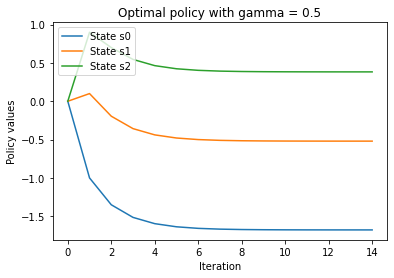

In [17]:
plot_history(V_his, gamma)

### Value iteration algorithm

The idea behind value iteration is quite similar to that of policy evaluation. It is also an iterative algorithm. It starts with arbitrary policy values and then iteratively updates the values based on the Bellman optimality equation until they converge. So in each iteration, instead of taking the expectation (average) of values across all actions, it picks the action that achieves the maximal policy values:

$$ V^*(s) = \max_a \left[ R(s,a) + \gamma \sum_{s'} T(s,a',s') V^*(s') \right] $$ 

$V^*(s)$ denotes the optimal value, which is the value of the optimal policy

Once the optimal values are computed, we obtain the optimal policy:

$$ \pi^*(s) = \text{argmax}_a \sum_{s'}T(s,a,s') \left[ R(s,a) + \gamma V^*(s') \right] $$ 

### Apply it to gym environment

In this step, we try to use *FrozenLake* environment to see how to implement the value iteration.

FrozenLake is a typical Gym environment with a discrete state space. It is about moving an agent from the starting location to the goal location in a grid world, and at the same time avoiding traps. Currently, We use four by four grid (https://gym.openai.com/envs/FrozenLake-v0/).

## OpenAI Gym

One of the popular simulation environment for RL is OpenAI Gym.

[OpenAI](https://openai.com) is a research company trying to develop systems exhibiting *artificial general intelligence* (AGI).
They developed Gym to support the development of RL algorithms. Gym
provides many reinforcement learning simulations and tasks. Visit [the Gym website](https://gym.openai.com) for a full list of environments.

<img src="img/RL_gym.PNG" title="Gym example" style="width: 600px;" />

### Install Gym

From your local machine, you can follow from [this step](https://github.com/Alisa-Kunapinun/Deep-Reinforcement-learning-lab/tree/main/01-Intro_RL_Setup). However, it is a little bit old (and the gym is update every 2 month!), so try to solve those problems yourself. :-)

In [18]:
# RUN apt-get update ; apt-get install -y x11-utils xvfb python-opengl
# RUN pip install pyglet gym pyvirtualdisplay
# RUN pip install -U gym==0.21.0
# RUN pip install gym[atari,accept-rom-license]

# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# !pip install -U gym==0.21.0
# !pip install -U gym[atari,accept-rom-license]

In [1]:
import gym
import torch
gym.__version__

'0.26.2'

#### Test it!

In [20]:
# !python SpaceInvaders.py

In [3]:
#For version : 0.26.2
# import matplotlib.pyplot as plt
# import gym
# from IPython import display
# %matplotlib inline

# env = gym.make("ALE/SpaceInvaders-v5", obs_type='rgb', render_mode='rgb_array')

# obs, info = env.reset()

# for i in range(20000):
#     action = env.action_space.sample()
#     obs, reward, terminated, truncated, info = env.step(action)
#     if i % 100 == 0:
#         plt.imshow(obs)
#         display.display(plt.gcf())    
#         display.clear_output(wait=True)
   
#     if terminated or truncated:
#         env.reset()

# env.close()

In [18]:
#For version : 0.21.0
# import gym
# import numpy as np
# import matplotlib.pyplot as plt
# from IPython import display as ipythondisplay

# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(400, 300))
# display.start()

# # env = gym.make("CartPole-v0")
# # env = gym.make("DoubleDunk-v0")
# env = gym.make("SpaceInvaders-v0")
# # env = gym.make("Acrobot-v1") # double invert pendulum
# env.reset()
# prev_screen = env.render(mode='rgb_array')
# plt.imshow(prev_screen)

# for i in range(20):
#     action = env.action_space.sample()
#     obs, reward, done, info = env.step(action)
#     # total = env.step(action)
#     screen = env.render(mode='rgb_array')

#     plt.imshow(screen)
#     ipythondisplay.clear_output(wait=True)
#     ipythondisplay.display(plt.gcf())

#     if done:
#         break

# ipythondisplay.clear_output(wait=True)
# env.close()

### Come back to Value Iteration

Import gym library and pytorch library.

In [23]:
import gym
import torch

In [26]:
gym.__version__

'0.26.2'

Create Frozen environment and take a look states and actions

In [5]:
#For version : 0.21.0
# env = gym.make("FrozenLake-v1")
#For version : 0.26.2
env = gym.make("FrozenLake-v1",render_mode='rgb_array')

n_state = env.observation_space.n
print("number of states:", n_state)

n_action = env.action_space.n
print("number of actions:", n_action)

number of states: 16
number of actions: 4


Reset and render the environment. Because the graphical of the environment is **text** style and no image pop-up. We can use render() directly.

**Note**: In the new version of gym, the environment is not text, so you need to use **pyvirtualdisplay**. These depend on your version. Check yourself!

state:  (0, {'prob': 1})


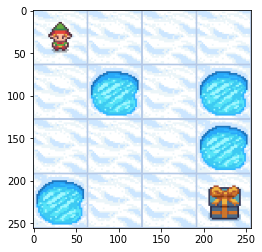

In [50]:
state = env.reset()
env.render()

img = plt.imshow(env.render()) # only call this once
img.set_data(env.render()) # just update the data
display.display(plt.gcf())
display.clear_output(wait=True)

print("state: ", state)

Try to put an down action to make the agent work.

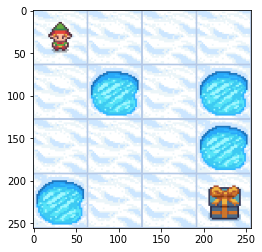

In [51]:
left = 0
down = 1
right = 2
up = 3
#For version : 0.21.0
# new_state, reward, is_done, info = env.step(down)
#For version : 0.26.2
new_state, reward, is_done, truncated , info = env.step(down)
env.render()
img = plt.imshow(env.render()) # only call this once
img.set_data(env.render()) # just update the data
display.display(plt.gcf())
display.clear_output(wait=True)

Check the output of environment class after take action. In the <code>info</code>, and <code>new_state</code>, it says that the agent lands in <code>new_state</code>, with probability 0.3333333333333333. The reward is 0 because the agent has not reached the goal and the episode is not done. You might see the agent landing in different state, or staying in state 0 because of the slippery surface.

In [52]:
print("state: ", new_state)

print("reward: ", reward)

print("Finish?: ", is_done)

print("information: ", info)

state:  0
reward:  0.0
Finish?:  False
information:  {'prob': 0.3333333333333333}


Define a function that simulates a FrozenLake episode given a policy and returns the total reward

In [53]:
# import time
def run_episode(env, policy, render=False):
    state,_ = env.reset()
    if render:
        env.render()
    total_reward = 0
    is_done = False
    step = 1
    while not is_done:
        action = policy[state].item()
        new_state, reward, is_done, truncated , info = env.step(down)
        if render:
            # time.sleep(500)
            print('step: ', step)
            # env.render()
            img = plt.imshow(env.render()) # only call this once
            img.set_data(env.render()) # just update the data
            display.display(plt.gcf())
            display.clear_output(wait=True)
        total_reward += reward
        step += 1
        if is_done:
            break
    return total_reward

Try to run 500 episodes with random policy, and see the results

We randomly generated a policy that was composed of 16 actions for the 16 states. Keep in mind that in FrozenLake, the movement direction is only partially dependent on the chosen action. This increases the uncertainty of control.

In [54]:
n_episode = 500
total_rewards = []

for episode in range(n_episode):
    # Create random policy with integer value deal to number of actions with n_state size.
    random_policy = torch.randint(high=n_action, size=(n_state,))
    # run an episode
    total_reward = run_episode(env, random_policy)
    total_rewards.append(total_reward)
    
    if total_reward == 1:
        best_policy = random_policy
        break
    
print('Average total reward under random policy: {}'.format(sum(total_rewards) / n_episode))
# see the best policy
print(best_policy)

Average total reward under random policy: 0.002
tensor([2, 3, 3, 1, 0, 1, 1, 3, 1, 3, 2, 0, 0, 3, 1, 1])


Try to run 500 episodes again using the <code>best_policy</code>, to check that the winning rate is good or not.

In [79]:
total_rewards = []

for episode in range(n_episode):# run an episode
    total_reward = run_episode(env, best_policy)
    total_rewards.append(total_reward)
    
print('Average total reward under best policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under best policy: 0.058


See the simulator

Total reward under best policy: 1.0


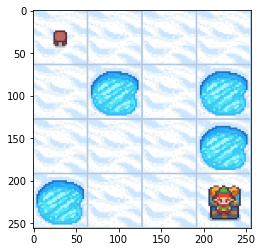

In [80]:
total_reward = run_episode(env, best_policy, True)

print('Total reward under best policy: {}'.format(total_reward))

### Solving FrozenLake with value iteration

At above, we found that the best policy from random policy is not good enough, so let's implement value iteration.

Set discount factor $\gamma$ as 0.9 and convergence threshold 0.000001

In [81]:
gamma = 0.9
threshold = 0.000001

Create value iteration function

In [84]:
def value_iteration(env, gamma, threshold):
    """
    Solve a given environment with value iteration algorithm
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for 
                       all states are less than the threshold
    @return: values of the optimal policy for the given 
              environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.empty(n_state)
        for state in range(n_state):
            v_actions = torch.zeros(n_action)
            for action in range(n_action):
                # calculate the optimal policy using probability in environment
                for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                    v_actions[action] += trans_prob * (reward + gamma * V[new_state])
            V_temp[state] = torch.max(v_actions)
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
            break
    return V

Find the optimal value using value iteration function

In [85]:
V_optimal = value_iteration(env, gamma, threshold)

print('Optimal values:\n{}'.format(V_optimal))

Optimal values:
tensor([0.0689, 0.0614, 0.0744, 0.0558, 0.0918, 0.0000, 0.1122, 0.0000, 0.1454,
        0.2475, 0.2996, 0.0000, 0.0000, 0.3799, 0.6390, 0.0000])


Create a function to extract from optimal value to be optimal policy.

In [86]:
def extract_optimal_policy(env, V_optimal, gamma):
    """
    Obtain the optimal policy based on the optimal values
    @param env: OpenAI Gym environment
    @param V_optimal: optimal values
    @param gamma: discount factor
    @return: optimal policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    optimal_policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward 
                           + gamma * V_optimal[new_state])
        optimal_policy[state] = torch.argmax(v_actions)
    return optimal_policy

In [87]:
optimal_policy = extract_optimal_policy(env, V_optimal, gamma)

print('Optimal policy:\n{}'.format(optimal_policy))

Optimal policy:
tensor([0., 3., 0., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


Try to run 500 episodes again using the <code>optimal_policy</code>, to check that the winning rate is good or not.

In [88]:
total_rewards = []

for episode in range(n_episode):# run an episode
    total_reward = run_episode(env, optimal_policy)
    total_rewards.append(total_reward)
    
print('Average total reward under optimal policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under optimal policy: 0.058


You can see that the optimal_policy accuracy is better than the random_policy.

### Policy iteration

Policy iteration starts with a random policy then uses policy evaluation and the resulting values to iteratively improve the policy until an optimal policy is obtained. It is, however,
slow, due to the policy evaluation loop within the policy iteration loop.

### Implement with policy iteration

A policy iteration algorithm can be subdivided into two components: policy evaluation and policy improvement. It starts with an arbitrary policy. And in each iteration, it first computes the policy values given the latest policy, based on the Bellman expectation equation; it then extracts an improved policy out of the resulting policy values, based on the Bellman optimality equation. It iteratively evaluates the policy and generates an improved version until the policy doesn't change any more.

$$ V(s) = \sum_{s'} T(s,a',s') \left[ R(s,a,s') + \gamma V(s') \right] $$ 

Once the optimal values are computed, we obtain the optimal policy:

$$ \pi(s) = \text{argmax}_a \sum_{s'}T(s,a,s') \left[ R(s,a,s') + \gamma V(s') \right] $$ 

Here's an implementation using a slightly different formulation fo the reward as a function $R(s,a,s')$ of the current state $s$, action taken $a$, and resulting state $s'$:

In [89]:
def policy_evaluation(env, policy, gamma, threshold):
    """
    Perform policy evaluation
    @param env: OpenAI Gym environment
    @param policy: policy matrix containing actions and 
                            their probability in each state
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values for all states are less than the threshold
    @return: values of the given policy
    """
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    while True:
        V_temp = torch.zeros(n_state)
        for state in range(n_state):
            action = policy[state].item()
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                V_temp[state] += trans_prob * (reward + gamma * V[new_state])
        max_delta = torch.max(torch.abs(V - V_temp))
        V = V_temp.clone()
        if max_delta <= threshold:
           break
    return V

In [90]:
def policy_improvement(env, V, gamma):
    """
    Obtain an improved policy based on the values
    @param env: OpenAI Gym environment
    @param V: policy values
    @param gamma: discount factor
    @return: the policy
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.zeros(n_state)
    for state in range(n_state):
        v_actions = torch.zeros(n_action)
        for action in range(n_action):
            for trans_prob, new_state, reward, _ in env.env.P[state][action]:
                v_actions[action] += trans_prob * (reward + gamma * V[new_state])
        policy[state] = torch.argmax(v_actions)
    return policy

Create policy_iteration function. The function combines policy_evaluation and policy_improvement.

In [91]:
def policy_iteration(env, gamma, threshold):
    """
    Solve a given environment with policy iteration algorithm
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param threshold: the evaluation will stop once values 
                    for all states are less than the threshold
    @return: optimal values and the optimal policy for the given 
              environment
    """
    n_state = env.observation_space.n
    n_action = env.action_space.n
    policy = torch.randint(high=n_action, size=(n_state,)).float()
    while True:
        V = policy_evaluation(env, policy, gamma, threshold)
        policy_improved = policy_improvement(env, V, gamma)
        if torch.equal(policy_improved, policy):
            return V, policy_improved
        policy = policy_improved

In [92]:
# try it
V_optimal, optimal_policy = policy_iteration(env, gamma, threshold)

print('Optimal values:\n{}'.format(V_optimal))
print('Optimal policy:\n{}'.format(optimal_policy))

Optimal values:
tensor([0.0689, 0.0614, 0.0744, 0.0558, 0.0918, 0.0000, 0.1122, 0.0000, 0.1454,
        0.2475, 0.2996, 0.0000, 0.0000, 0.3799, 0.6390, 0.0000])
Optimal policy:
tensor([0., 3., 0., 3., 0., 0., 0., 0., 3., 1., 0., 0., 0., 2., 1., 0.])


Try to run 500 episodes again using the <code>optimal_policy</code>, to check that the winning rate is good or not.

In [93]:
total_rewards = []

for episode in range(n_episode):# run an episode
    total_reward = run_episode(env, optimal_policy)
    total_rewards.append(total_reward)
    
print('Average total reward under optimal policy: {}'.format(sum(total_rewards) / n_episode))

Average total reward under optimal policy: 0.044


### Atari games environment

Atari games includes video games such as Alien, Pong, and Space Race. Here is the example of using the Space Invaders game.

Let's create a Space Invaders environment:

In [96]:
import gym
# create environment
#For version : 0.21.0
# env = gym.make('SpaceInvaders-v0')
#For version : 0.26.2
env = gym.make('SpaceInvaders-v4',render_mode='rgb_array')
# reset environments
env.reset()

(array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]]], dtype=uint8),
 {'lives': 3, 'episode_frame_number': 0, '

Render the environment locally. (You cannot render in Jupyter, or let us know if you find a way!)

Locally, you should get output like this:

<img src="img/RL_SpaceInvaders.PNG" title="Space Invaders" style="width: 600px;" />

for i in range(20):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if i % 100 == 0:
        plt.imshow(obs)
        display.display(plt.gcf())    
        display.clear_output(wait=True)
   
    if terminated or truncated:
        env.reset()

env.close()After rendering, you'll want to close the environment.

<font size="3" color="red"><b>WARNING</b></font>
    
In JUPYTER NOTEBOOK or JUPYTER LAB, you need to use <code><font color='red'>env.close()</font></code> after <code>env.render()</code>, unless the program will stuck.

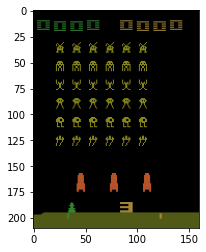

In [100]:
for i in range(20):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    if i % 100 == 0:
        plt.imshow(obs)
        display.display(plt.gcf())    
        display.clear_output(wait=True)
   
    if terminated or truncated:
        env.reset()

env.close()

In [99]:
# Example 1

# import time
# env.render()
# time.sleep(5)
# # close the environment
# env.close()

In [104]:
# import time
# env.render()
# for i in range(200):
#     img = plt.imshow(env.render()) # only call this once
#     img.set_data(env.render()) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)

# # time.sleep(5)
# # close the environment
# env.close()

If you cannot use Atari games due to errors occurring in Windows, you can try another simulator such as CartPole (inverted pendulum):

<img src="img/RL_CartPole.PNG" title="Cart pole" style="width: 600px;" />

In [109]:
# Example 2

#import gym
#import time
# create environment
# env = gym.make('CartPole-v0')

# reset environments
# env.reset()

# render the environment
#env.render()
#time.sleep(5)

#env.close()

Before try the example above, I have another solution that you can use gym run in Jupyter notebook.
One is MP4 and another is real-time showing. <link>[In this link](https://kyso.io/eoin/openai-gym-jupyter#code=both)</link>

### Way1: MP4 Running

Save the simulation as an mp4 and save it at the end. This method makes the simulation faster since there is no visualising happening every step. In this simulation we just make the space ship take a random move each step.

In [79]:
# import gym
# from gym import wrappers

# env = gym.make('SpaceInvaders-v0')
# env = wrappers.Monitor(env, "./gym-results", force=True)
# env.reset()
# for _ in range(1000):
#     action = env.action_space.sample()
#     observation, reward, done, info = env.step(action)
#     if done: break
# env.close()

And show MP4 vdo by this code

In [80]:
# import io
# import base64
# from IPython.display import HTML

# video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % env.file_infix, 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''
#     <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
# .format(encoded.decode('ascii')))

### Way2: Show as gif in realtime

This method is useful for look at the simulation in realtime, but it does make the simulation take longer. It does not save the gif, but if you run this cell you will the image change as the simulation progresses.

In [ ]:
!pip install gym[box2d]

In [113]:
# import gym
# from IPython import display
# import matplotlib
# import matplotlib.pyplot as plt
# %matplotlib inline

# env = gym.make('CarRacing-v2')
# env.reset()
# plt.figure(figsize=(9,9))
# #img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# for _ in range(100):
#     #img.set_data(env.render(mode='rgb_array')) # just update the data
#     #display.display(plt.gcf())
#     #display.clear_output(wait=True)
#     # env.render()
#     img = plt.imshow(env.render()) # only call this once
#     img.set_data(env.render()) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     action = env.action_space.sample()
#     env.step(action)
# env.close()

In [ ]:
#For version : 0.26.0
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('CarRacing-v2',render_mode="rgb_array")
env.reset()
plt.figure(figsize=(9,9))
img = plt.imshow(env.render()) # only call this once
for _ in range(100):
    img.set_data(env.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    # env.render()
    action = env.action_space.sample()
    env.step(action)
env.close()

#### In this lab, I recommend you to use the way2 for smoother working ;-)

Take a look at the action space available, and try to get a sample from the action space:

In [114]:
print(env.action_space)
action = env.action_space.sample()
print(action)

Discrete(2)
0


Execute an action using `step()`.
The `step` method returns the next state after the action is taken.
 - **new_state**: The new observation
 - **reward**: The reward associated with that action in that state.
 - **is_done**: A flag to tell the game end (True).
 - **info**: extra information

In [47]:
# new_state, reward, is_done, info = env.step(action)
#For version 0.26.2
new_state, reward, is_done,_, info = env.step(action)
print(is_done)
print(reward)
print(info)

False
-0.10000000000000009
{}


Let's make a *while* loop with a random agent:

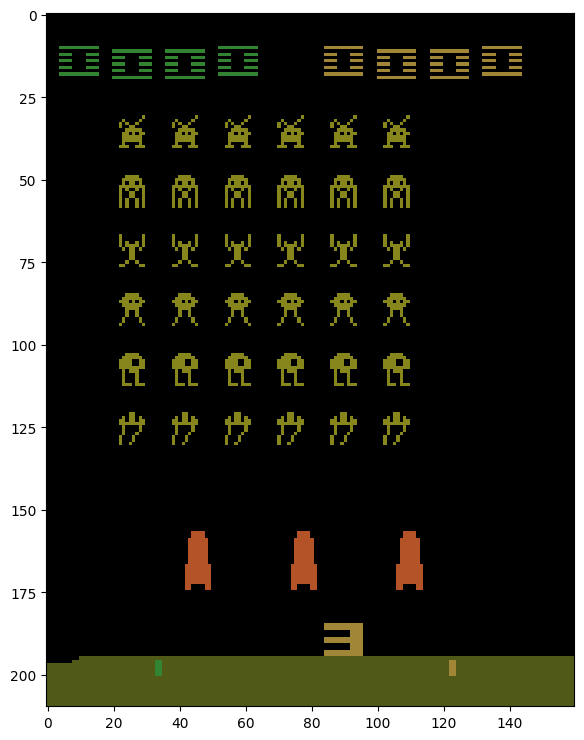

In [50]:
# import time

# is_done = False
# env = gym.make('SpaceInvaders-v0')
# env.reset()
# plt.figure(figsize=(9,9))
# img = plt.imshow(env.render(mode='rgb_array')) # only call this once
# step = 0
# while step >= 2:
# # while not is_done:
#     action = env.action_space.sample()
#     new_state, reward, is_done, info = env.step(action)
#     print(info)
#     img.set_data(env.render(mode='rgb_array')) # just update the data
#     display.display(plt.gcf())
#     display.clear_output(wait=True)
#     time.sleep(0.03)
#     step += 1
# env.close()

## Using the environments to do reinforcement learning

## Monte Carlo (MC) Method

Monte Carlo method is a model-free which have no require any prior knowledge of the environment. MC method is more scalable than MDP. MC control is used for finding the optimal policy when a policy is not given. There are 2 basically of MC control: on-policy and off-policy. On-policy method learns about the optimal policy by executing the policy and evaluating and improving it, while Off-policy method learns about the optimal policy using data generated by another policy.

## Monte Carlo Method Concept

MC method is any mothod that uses randomness to solve problems. The algorithm repeats suitable **random sampling** and observes the fraction of samples that obey particular properties in order to make numerical estimations.

## Find $\pi$ using MC method

$\pi$? Yes the $\pi$ which is used for calculate circle. We assume that if there are some random points which are in the square area. We can calculate $\pi$ by

$$ A_{rect} = (2r)^2 = 4r^2 $$
$$ A_{circle} = \pi r^2 $$

Hence,
$$ \frac{A_{circle}}{A_{rect}} = \frac{\pi r^2}{4r^2} = \frac{\pi}{4} $$

Let's try to code:

In [6]:
import torch
import numpy
import math
import matplotlib.pyplot as plt

Random 2,000 points in the square $x \in [-1,1]$ and $y \in [-1,1]$

In [7]:
n_point = 2000
points = torch.rand((n_point, 2)) * 2 - 1

Find the points which are inside the circle, and keep them (this is for plot in the graph only)


In [8]:
points_circle_x = []
points_circle_y = []
n_point_circle = 0

pi_iteration = []
i = 1
for point in points:
    r = torch.sqrt(point[0] ** 2 + point[1] ** 2)
    if r <= 1:
        points_circle_x.append(point[0])
        points_circle_y.append(point[1])
        n_point_circle += 1
    pi_iteration.append(4 * (n_point_circle / i))
    i += 1
        
points_circle_x = numpy.asarray(points_circle_x)
points_circle_y = numpy.asarray(points_circle_y)

Find the estimate $\pi$

In [9]:
pi_estimated = 4 * n_point_circle / n_point
print('Estimated value of pi is:', pi_estimated)

Estimated value of pi is: 3.142


Plot to show the points and circle

TypeError: linspace() missing 1 required positional arguments: "steps"

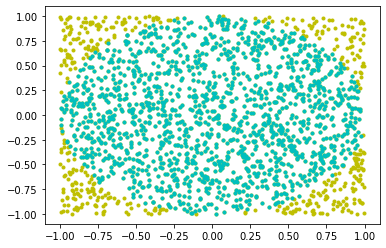

In [10]:
plt.plot(points[:, 0].numpy(), points[:, 1].numpy(), 'y.')
plt.plot(points_circle_x, points_circle_y, 'c.')
# plot real circle
i = torch.linspace(0, 2 * math.pi)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'r-')
# plot circle from estimate pi
i = torch.linspace(0, 2 * pi_estimated)
plt.plot(torch.cos(i).numpy(), torch.sin(i).numpy(), 'b--')
plt.axes().set_aspect('equal')
plt.show()

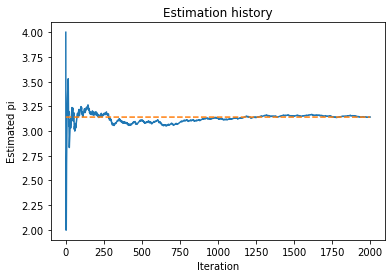

In [11]:
plt.plot(pi_iteration)
plt.plot([math.pi] * n_point, '--')
plt.xlabel('Iteration')
plt.ylabel('Estimated pi')
plt.title('Estimation history')
plt.show()

### Monte Carlo Policy Evaluation

Last time, we applied **DP** algorithm into policy evaluation. The things we need are:

- Full state-value transition matrix
- Reward matrix

Those are fully known environment. However, in real-life situation, we don't know before we reach the situation. This is the **limitation of model-base algorithm**. To address the problem, the **model-free algorithm** is created for no pre-required prior knowledge both transition and rewards matrices.

We need to recall the returns of **Giving Policy (G)** from a process, which are the total rewards over the long run, 

$$G_t=\sum_k \gamma^k R_{t+k+1}$$

MC policy evaluation uses **empirical mean return** instead of **expected return (as in DP)** to estimate the value function. There are two ways to perform MC policy evaluation.
- First-visit MC prediction -- averages the returns only for the first occurrence of a state, s, in an episode. 
- Every-visit MC prediction -- averages the returns for every occurrence of a state, s, in an episode.

First-visit MC prediction has fewer calculations than the every-visit version, so it is more frequently used.

### Incremental means

To update the MC method, the incremenatl means have been used for update the policy. An incremental or running mean allows us to keep an average for a list of numbers without having to remember the list. We hold one value that we incrementally update using the following equation:

$$V(S_t) = V(S_t) + \alpha(G_t + V(S_t))$$

When $V(S_t)$ is the current state value for the policy, $\alpha$ is a discount rate, and $G_t$.

### FrozenLake and First-visit MC policy evaluation

Let's start in FrozenLake environment using first-visit MC prediction.

In [12]:
import torch
import gym

env = gym.make("FrozenLake-v1")

In [13]:
gym.__version__

'0.26.2'

Create a function which simulate for each episode given a policy and returns the reward and state for each step

In [15]:
def run_episode(env, policy):
    state = env.reset()
    # this is the difference between MC and DP, find rewards and states
    rewards = []
    states = [state]
    is_done = False
    while not is_done:
        action = policy[state].item()
        state, reward, is_done,_, info = env.step(action)
        # keep all states and reward
        states.append(state)
        rewards.append(reward)
        if is_done:
            break
    # convert to torch
    states = torch.tensor(states)
    rewards = torch.tensor(rewards)
    return states, rewards

Create MC prediction in first-visit.

In [16]:
def mc_prediction_first_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    for episode in range(n_episode):
        # run 1 episode until end of the episode
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        first_visit = torch.zeros(n_state)
        G = torch.zeros(n_state)
        # take a look the state and reward from the last to first start
        # calculate given policy
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            # calculate rewards
            # because the reward at the last can be only 0 or 1, otherwise are 0
            # so the reward at first start will be smallest
            return_t = gamma * return_t + reward_t
            # put the reward for the state into given policy
            # as you can see, if we come in the same state, it will be replaced to the early time when visit
            # That's why we call first-visit
            G[state_t] = return_t
            first_visit[state_t] = 1
        # at the end of given policy calculation
        # we need to update the state transition by summation them (prepare to average)
        for state in range(n_state):
            if first_visit[state] > 0:
                V[state] += G[state]
                N[state] += 1
    # average state transition here
    for state in range(n_state):
        if N[state] > 0:
            V[state] = V[state] / N[state]
    return V

Setup discount rate $\gamma$ as 1 and simulate 10,000 episodes

We tried to used <code>optimal_policy</code> from lab 02 (don't be worry, we just bring the data), and feed it into the first-visit MC function, and see the results.

In [24]:
gamma = 1
n_episode = 10000

optimal_policy = torch.tensor([0., 3., 3., 3., 0., 3., 2., 3., 3., 1., 0., 3., 3., 2., 1., 3.])
value = mc_prediction_first_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by first-visit MC prediction:\n', value)

As you can see, in MC-based prediction, it is not necessary to know about the full model of the environment. In most real-world cases, the transition matrix and reward matrix are not known beforehand, or are extremely difficult to obtain. Imagine how many possible states there are playing *chess* or *Go* and the number of possible actions; it is almost impossible to work out the transition matrix and reward matrix. Model-free reinforcement learning is about learning from experience by interacting with the environment.

We only considered what could be observed, which included the new state and reward in each step, and made predictions using the Monte Carlo method.

Note that the more episodes we simulate, the more accurate predictions we can obtain. If you plot the value updated after each episode, you will see how it converges over time, which is similar to what we saw when estimating the value of $\pi$.

### How about every-visit MC?

Take a look at every-visit MC function

In [19]:
def mc_prediction_every_visit(env, policy, gamma, n_episode):
    n_state = policy.shape[0]
    V = torch.zeros(n_state)
    N = torch.zeros(n_state)
    G = torch.zeros(n_state)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, policy)
        return_t = 0
        for state_t, reward_t in zip(reversed(states_t)[1:], reversed(rewards_t)):
            return_t = gamma * return_t + reward_t
            # Here is the difference, instead of discard the other visit
            # we calculate all visiting in the target state
            # That's why call every-visit
            G[state_t] += return_t
            N[state_t] += 1
    for state in range(n_state):
        if N[state] > 0:
            V[state] = G[state] / N[state]
    return V

In [23]:
e_value = mc_prediction_every_visit(env, optimal_policy, gamma, n_episode)
print('The value function calculated by every-visit MC prediction:\n', e_value)

Actually, the every-visit is more accurate than the first-visit, but it takes a lot of calculation, so it is not popular.

## On-policy Monte Carlo control

On-policy Monte Carlo works look-a-like to policy iteration which has 2 phases: evaluation and improvement.
 - Evaluation phase: it evaluates the **action-values** (called **Q-function** $Q(s,a)$) instead of evaluates the value function.
 - Improvement phase: the policy is updated by assigning the optimal action to each stage: $\pi(s)=argmax_a Q(s,a)$
      
### Developing MC control with epsilon-greedy policy

The optimal policy using MC control can find the action with the highest state-action value was selected. However, the best choice available in early episodes does not guarantee an optimal solution. If we just focus on what is temporarily the best option and ignore the overall problem, we will be stuck in local optima instead of reaching the global optimal. In order to address the problem, we use another algorithm: epsilon-greedy policy.

In MC control with epsilon-greedy policy, we no longer exploit the best action all the time, but choose an action randomly under certain probabilities. As the name implies, the algorithm has two folds:

$$\pi(s,a) = \frac{\epsilon}{|A|}$$

when $|A|$ is the number of possible actions

#### Greedy

Greedy is the action with the highest state-action value is favored, and its probability of being chosen is increased by $1-\epsilon$:

$$\pi(s,a) = 1 - \epsilon + \frac{\epsilon}{|A|}$$

Epsilon-greedy policy exploits the best action most of the time and also keeps exploring different actions from time to time.

## Modify MC control with epsilon-greedy policy with FrozenLake

From the code above, let's modify as below:

In [25]:
import torch
import gym

env = gym.make("FrozenLake-v1")

In [26]:
gym.__version__

'0.26.2'

Modify run_episode to return states, actions, rewards

In [27]:
def run_episode(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

Create MC_control using epsilon greedy

In [28]:
from collections import defaultdict

def mc_control_epsilon_greedy(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        if (episode + 1) % 1000 == 0:
            print("Training episode {}".format(episode+1))
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


Find optimal policy

In [32]:
# gamma = 1

# n_episode = 100000
epsilon = 0.1

# optimal_Q, optimal_policy = mc_control_epsilon_greedy(env, gamma, n_episode, epsilon)

To test the optimal policy, we need to run simulation using policy.

Let's create simulate_episode function:

In [33]:
def simulate_episode(env, policy):
    state = env.reset()
    is_done = False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

Run the optimal policy

In [69]:
n_episode = 50000
n_win_optimal = 0
n_lose_optimal = 0

for episode in range(n_episode):
    if (episode + 1) % 1000 == 0:
        print("Testing episode {}".format(episode+1))
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1

Testing episode 1000
Testing episode 2000
Testing episode 3000
Testing episode 4000
Testing episode 5000
Testing episode 6000
Testing episode 7000
Testing episode 8000
Testing episode 9000
Testing episode 10000
Testing episode 11000
Testing episode 12000
Testing episode 13000
Testing episode 14000
Testing episode 15000
Testing episode 16000
Testing episode 17000
Testing episode 18000
Testing episode 19000
Testing episode 20000
Testing episode 21000
Testing episode 22000
Testing episode 23000
Testing episode 24000
Testing episode 25000
Testing episode 26000
Testing episode 27000
Testing episode 28000
Testing episode 29000
Testing episode 30000
Testing episode 31000
Testing episode 32000
Testing episode 33000
Testing episode 34000
Testing episode 35000
Testing episode 36000
Testing episode 37000
Testing episode 38000
Testing episode 39000
Testing episode 40000
Testing episode 41000
Testing episode 42000
Testing episode 43000
Testing episode 44000
Testing episode 45000
Testing episode 460

In [70]:
print('Winning probability under the optimal policy: {}'.format(n_win_optimal/n_episode))

print('Losing probability under the optimal policy: {}'.format(n_lose_optimal/n_episode))

Winning probability under the optimal policy: 0.25438
Losing probability under the optimal policy: 0.0


## Implement other environments: LunarLander

Let's see the environment:

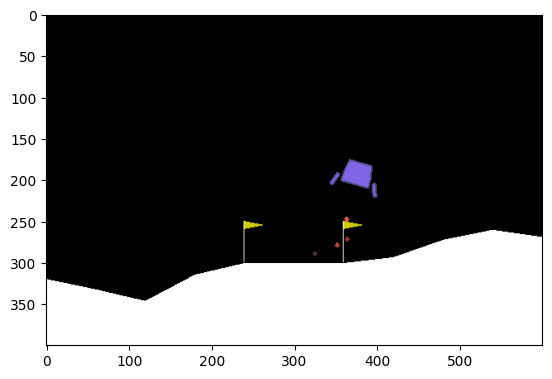

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make('LunarLander-v2')

env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')

    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())

    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

Checking state in the environment.

In [2]:
state = env.reset()
print(state)

[ 0.00296688  1.408531    0.3004886  -0.10618901 -0.00343099 -0.06806513
  0.          0.        ]


Because the state is floating array, It is not good for creating the Q table. We try to change the state to integer array and convert the state array to tuple

In [3]:
state = tuple((state * 10).astype(int))
print(state)

(0, 14, 3, -1, 0, 0, 0, 0)


Modify run_episode function for supporting the state.

In [4]:
import numpy as np
import torch

def run_episode2(env, Q, epsilon, n_action):
    """
    Run a episode and performs epsilon-greedy policy
    @param env: OpenAI Gym environment
    @param Q: Q-function
    @param epsilon: the trade-off between exploration and exploitation
    @param n_action: action space
    @return: resulting states, actions and rewards for the entire episode
    """
    state = env.reset()
    state = tuple((state * 10).astype(int))
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = torch.ones(n_action) * epsilon / n_action
        #print(Q)
        #print(state)
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        state = tuple((state * 10).astype(int))
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

In [5]:
from collections import defaultdict

def mc_control_epsilon_greedy2(env, gamma, n_episode, epsilon):
    """
    Obtain the optimal policy with on-policy MC control with epsilon_greedy
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @param epsilon: the trade-off between exploration and exploitation
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        if (episode + 1) % 500 == 0:
            print("Training episode {}".format(episode+1))
        states_t, actions_t, rewards_t = run_episode2(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action

            G_sum[state_action] += return_t
            N[state_action] += 1
            Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [6]:
gamma = 0.5

n_episode = 5000
epsilon = 0.1

optimal_Q, optimal_policy = mc_control_epsilon_greedy2(env, gamma, n_episode, epsilon)

Training episode 500
Training episode 1000
Training episode 1500
Training episode 2000
Training episode 2500
Training episode 3000
Training episode 3500
Training episode 4000
Training episode 4500
Training episode 5000


In [7]:
len(optimal_policy)

188934

In [8]:
def simulate_episode_render(env, policy):
    state = env.reset()
    state = tuple((state * 10).astype(int))
    is_done = False
    while not is_done:
        try:
            action = policy[state]
            print("get action")
        except:
            action = 0
            print("no action")
        print(action)
        state, reward, is_done, info = env.step(action)
        state = tuple((state * 10).astype(int))
        screen = env.render(mode='rgb_array')
        
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        if is_done:
            return reward

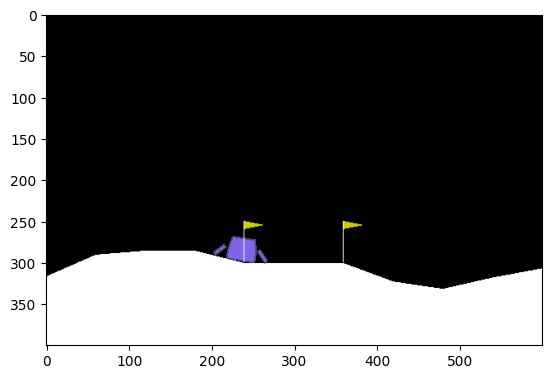

In [9]:
from gym.wrappers import Monitor

vdo_path = 'video_rl/'
env = Monitor(gym.make('LunarLander-v2'), vdo_path, force=True)
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

simulate_episode_render(env, optimal_policy)

ipythondisplay.clear_output(wait=True)
env.close()

### Another example: Blackjack

In [34]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v1')

def run_episode(env, Q, epsilon, n_action):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    # without epsilon-greedy
    # action = torch.randint(0, n_action, [1]).item()
    ##################################################
    while not is_done:
        # with epsilon-greedy
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        #######################################################
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
    return states, actions, rewards

def mc_control_on_policy(env, gamma, n_episode, epsilon):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(env.action_space.n))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, epsilon, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            for state_action, return_t in G.items():
                state, action = state_action
                if state[0] <= 21:
                    G_sum[state_action] += return_t
                    N[state_action] += 1
                    Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
epsilon = 0.1
optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode, epsilon)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

TypeError: unhashable type: 'dict'

## Off-policy Monte Carlo control

The Off-policy method optimizes the **target policy** ($\pi$) using data generated by another policy (**behavior policy** ($b$)).
 - Target policy: exploitation purposes, greedy with respect to its current Q-function.
 - Behavior policy: exploration purposes, generate behavior which the target policy used for learning. The behavior policy can be anything to confirm that it can explore all possibilities, then all actions and all states can be chosen with non-zero probabilities.

The weight importand for state-action pair is calculated as:

$w_t=\sum_{k=t}[\pi(a_k|s_k)/b(a_k|s_k)]$
 - $\pi(a_k|s_k)$: probabilities of taking action $a_k$ in state $s_k$
 - $b(a_k|s_k)$: probabilities under the behavior policy.

In [35]:
import torch
import gym
from collections import defaultdict

env = gym.make('Blackjack-v1')

def gen_random_policy(n_action):
    probs = torch.ones(n_action) / n_action
    def policy_function(state):
        return probs
    return policy_function

random_policy = gen_random_policy(env.action_space.n)

def run_episode(env, behavior_policy):
    state = env.reset()
    rewards = []
    actions = []
    states = []
    is_done = False
    while not is_done:
        probs = behavior_policy(state)
        action = torch.multinomial(probs, 1).item()
        actions.append(action)
        states.append(state)
        state, reward, is_done, info = env.step(action)
        rewards.append(reward)
        if is_done:
            break
    return states, actions, rewards

def mc_control_off_policy(env, gamma, n_episode, behavior_policy):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        W = {}
        w = 1
        states_t, actions_t, rewards_t = run_episode(env, behavior_policy)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
            w *= 1./ behavior_policy(state_t)[action_t]
            W[(state_t, action_t)] = w
            if action_t != torch.argmax(Q[state_t]).item():
                break
            
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t * W[state_action]
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

gamma = 1
n_episode = 500000
optimal_Q, optimal_policy = mc_control_off_policy(env, gamma, n_episode, random_policy)
# print(optimal_policy)
# print(optimal_Q)

def simulate_episode(env, policy):
    state = env.reset()
    is_done= False
    while not is_done:
        action = policy[state]
        state, reward, is_done, info = env.step(action)
        if is_done:
            return reward

n_episode = 100
n_win_optimal = 0
n_lose_optimal = 0
for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_optimal += 1
    elif reward == -1:
        n_lose_optimal += 1
print('after episode 100, win ', n_win_optimal, ' lose ', n_lose_optimal)

ValueError: too many values to unpack (expected 4)

## Temporal Difference (TD)

**Makov Decision Process (MDP)** using **Monte Carlo method** which it a *model-free* approach. It does not require the prior knowledge environment. However, all algorithm that we learned, need to play until the end of episode, then it can update its knowledge. This is slow due to waiting some process to success or fail to terminate.

For **Temporal Difference(TD)**, it is another method that can learn while it's running each step because learning every time step in an episode, TD increased learning efficiency significantly.

Temporal Difference (TD) learning is a model-free learning algorithm like MC learning. In MC learning, Q-function is called and updated at the end of the entire episode, but TD learning update Q-function every step of an episode. One of the TD learning algorithm is Q-learning

## Algorithms in TD method

The TD method has 2 main algorithms family:
1. Q-Learning
2. SARSA

## Q-Learning

Q-Learning is a very popular TD method. It is an off-policy learning algorithm. The Q-function updates the Q policy based on the equation:

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma \max_{a'}Q(s',a') - Q(s,a))$$

where
- s: currenct state
- s': next state after taking action
- a: action in the current state
- a': action will take when go to next state
- $\alpha$: learning rate
- $\gamma$: discount factor

$\max_{a'}Q(s',a')$ means the behavior policy is greedy, where the highest Q-value among those in state $s'$ is selected to generate learning data.

In Q-learning, actions are taken according to the epsilon-greedy policy.

## Q-Learning example: SpaceInvaders

Now, let's do the Q-Learning algorithm using SpaceInvaders environment.

In [36]:
import torch
import gym
from collections import defaultdict
import numpy

env_id = "SpaceInvaders-v0"
env = gym.make(env_id)

env.reset()

(array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],
 
        ...,
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]],
 
        [[80, 89, 22],
         [80, 89, 22],
         [80, 89, 22],
         ...,
         [80, 89, 22],
         [80, 89, 22],
         [80, 89, 22]]], dtype=uint8),
 {'lives': 3, 'episode_frame_number': 0, '

### Define Epsilon greedy policy

As last time the epsilon greedy policy equation can be written as:

$$\pi(s,a) = \frac{\epsilon}{|A|}$$

when $|A|$ is the number of possible actions, and

$$\pi(s,a) = 1 - \epsilon + \frac{\epsilon}{|A|}$$

In [37]:
def gen_epsilon_greedy_policy(n_action, epsilon):
    def policy_function(state, Q, available_actions):
        probs = torch.ones(n_action) * epsilon / n_action
        best_action = torch.argmax(Q[state]).item()
        if not(best_action in available_actions):
            best_action = -1
            Q_max = -800000000
            for i in range(n_action):
                if i in available_actions and Q_max < Q[state][i]:
                    Q_max = Q[state][i]
                    best_action = i
        probs[best_action] += 1.0 - epsilon
        action = torch.multinomial(probs, 1).item()
        return action
    return policy_function

### Define Q-learning function

We perform Q-learning in the tasks:

1. Initialize the Q-table with all zeros.
2. In each episode, we let the agent follow the epsilon-greedy policy to choose what action to take. And we update the Q function for each step.
3. Run <code>n_episodes</code> episodes
4. Obtain the optimal policy based on the optimal Q function.

In [38]:
def q_learning(env, gamma, n_episode, alpha, player):
    """
    Obtain the optimal policy with off-policy Q-learning method
    @param env: OpenAI Gym environment
    @param gamma: discount factor
    @param n_episode: number of episodes
    @return: the optimal Q-function, and the optimal policy
    """
    n_action = 9
    Q = defaultdict(lambda: torch.zeros(n_action))
    print('start learning')
    for episode in range(n_episode):
        print("episode: ", episode + 1)
        state = env.reset()
        state = hash(tuple(state.reshape(-1)))

        is_done = False
        while not is_done:
            action = epsilon_greedy_policy(state, Q, available_actions)
            next_state, reward, is_done, info = env.step(action)
            next_state = hash(tuple(next_state.reshape(-1)))
            td_delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * td_delta

            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if is_done:
                break
            state = next_state

    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy

### Define initial parameters

We specify the $\gamma=1$, $\alpha=0.4$, and $\epsilon=0.1$ with 500 episodes

In [39]:
gamma = 1
alpha = 0.4
epsilon = 0.1

n_episode = 500

### Create an instance of the epsilon-greedy policy function

In [40]:
available_actions = numpy.arange(env.action_space.n)
available_actions = torch.from_numpy(available_actions)
epsilon_greedy_policy = gen_epsilon_greedy_policy(env.action_space.n, epsilon)

print(epsilon_greedy_policy)

<function gen_epsilon_greedy_policy.<locals>.policy_function at 0x000001299FB64CA0>


### Train it!

In [41]:
length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

# agent play first
optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, 1)


print('The optimal policy:\n', optimal_policy)

start learning
episode:  1


AttributeError: 'tuple' object has no attribute 'reshape'

### Display the plot of episode

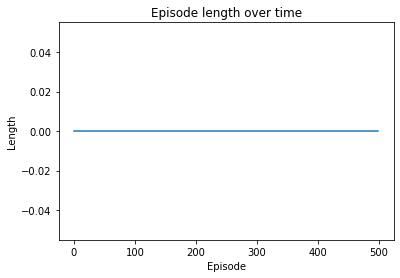

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


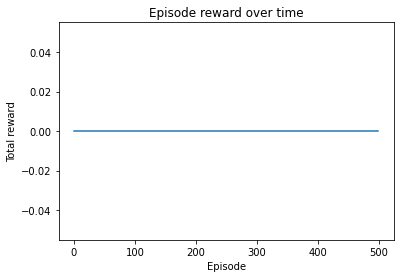

In [42]:
import matplotlib.pyplot as plt

plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')
plt.show()


plt.plot(total_reward_episode)
print(total_reward_episode[-100:])
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.show()

### Simulate the optimal policy

In [43]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(Q, available_actions):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    state = hash(tuple(state.reshape(-1)))
    while(not done):
        action = epsilon_greedy_policy(state, Q, available_actions)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state
        state = hash(tuple(state.reshape(-1)))

play_game(optimal_Q, available_actions)
env.close()

NameError: name 'optimal_Q' is not defined

## Deep Q-Learning

A deep Q-Network (DQN) is similar to a supervised regression model $F_{\theta}$, but it more specifically maps states to action values directly instead of using a set of features.

A DQN is trained to output $Q(s,a)$ values for each action given the input state $s$. In operation, in state $s$, the action $a$ is chosen greedily based on $Q(s,a)$ or stochastically
following an epsilon-greedy policy.

<img src="img/RL2_DQN.png" title="DQN" style="width: 800px;" />

In tabular Q learning, the update rule is an off-policy TD learning rule. When we take
action $a$ in state $s$ receiving reward $r$, we update $Q(s,a)$ as

$$Q(s,a)=Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a')-Q(s,a)),$$

where
 - $s'$ is the resulting state after taking action $a$ in state $s$
 - $\max_{a'}Q(s',a')$ is value of the action $a'$ we would take in state $s'$ according to a greedy behavior policy.

A DQN does the same thing using backpropagation, minimizing inconsistencies in its $Q$ estimates. At each step, the difference
between the estimated value and the observed data from the subsequent step should be minimized, giving us a kind of regression
problem, for which a squared error loss function is appopriate, giving us a delta for the $a$th output of

$$\delta_a=r+\gamma\max_{a'}Q(s')_{a'}-Q(s)_{a}.$$

With an appropriate exploration strategy and learning rate, DQN should find the optimal network model best approximating
the state-value function $Q(s,a)$ for each possible state and action.

## DQN Example: Cartpole

Let's develop a sample DQN application step by step. First, some imports we'll need.

**Note**: From now, the coding style have changed for supporting more advance coding.

In [49]:
import math, random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import matplotlib.pyplot as plt

import gym
import numpy as np

from collections import deque
from tqdm import trange

# Select GPU or CPU as device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### $\epsilon$ decay schedule

$\epsilon$ is how much the model use the policy action as random. At first, we want $\epsilon$ high as possible to explore the new path, and the $\epsilon$ will decreased to exploit the policy at the old state that we have explored.

Recall that some of the theoretical results on TD learning assume $\epsilon$-greedy exploration with $\epsilon$ decaying slowly to 0
over time. Let's define an exponential decay schedule for $\epsilon$. First, an example:

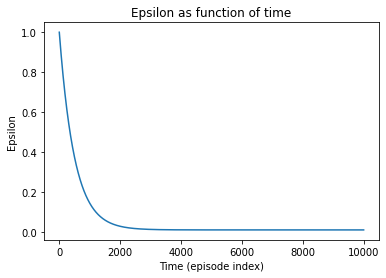

In [50]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

# Define epsilon as a function of time (episode index)

eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

# Note that the above lambda expression is equivalent to explicitly defining a function:
# def epsilon_episode(episode):
#     return epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)

plt.plot([eps_by_episode(i) for i in range(10000)])
plt.title('Epsilon as function of time')
plt.xlabel('Time (episode index)')
plt.ylabel('Epsilon')
plt.show()

Here's a reusable function to generate an annealing schedule function according to given parameters:

In [51]:
# Epsilon annealing schedule generator

def gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay):
    eps_by_episode = lambda episode: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * episode / epsilon_decay)
    return eps_by_episode

epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500
eps_by_episode = gen_eps_by_episode(epsilon_start, epsilon_final, epsilon_decay)

### Replay buffer

We know that deep learning methods learn faster when training samples are combined into batches. This speeds up learning and also makes it more stable by averaging
updates over multiple samaples.

RL algorithms also benefit from batched training. However, we see that the standard Q learning rule always updates $Q$ estimates using the most recent experience.
If we always trained on batches consisting of samples of the most recent behavior, correlations between successive state action pairs will make learning less effective.
So we would also like to select random training samples to make them look more like the i.i.d. sampling that supervised learning performs well under.

In RL, the standard way of doing this is to create a large buffer of past state action pairs then form training batches by sampling from that replay buffer.
Our replay buffer will store tuples consisting of an observed state, an action, the next_state, the reward, and the termination signal obtained by the agent at that point in time:

In [104]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        # Add batch index dimension to state representations
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [105]:
from collections import namedtuple, deque
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayBuffer(object):

    def __init__(self, capacity):
        self.buffer = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

### Basic DQN

Next, a basic DQN class. We just create a neural network that takes as input a state
and returns an output vector indiciating the value of each possible action $Q(s,a)$.

The steps we take during learning will be as follows:

<img src="img/RL2_DQNstep.jpeg" title="" style="width: 600px;" />

To implement the policy, besides the usual `forward()` method, we add one additional method `act()`,
which samples an $\epsilon$-greedy action for state $s$ using the current estimate $Q(s,a)$.
`act()` will be used to implement step 1 in the pseudocode above.


In [106]:
class DQN(nn.Module):
    
    def __init__(self, n_state, n_action):
        super(DQN, self).__init__()        
        self.layers = nn.Sequential(
            nn.Linear(n_state, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_action)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        # Get an epsilon greedy action for given state
        if random.random() > epsilon: # Use argmax_a Q(s,a)
            state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
            q_value = self.forward(state)
            q_value = q_value.cpu()
            action = q_value.max(1)[1].item()            
        else: # get random action
            action = random.randrange(env.action_space.n)
        return action

### Create gym environment, prepare DQN for training

Next we set up a gym environment for the cartpole simulation, create a DQN model with Adam optimization, and create a replay buffer of length 1000.

In [107]:
env_id = "CartPole-v1"
env = gym.make(env_id)

model = DQN(env.observation_space.shape[0], env.action_space.n).to(device)
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(3000)

### Training step

In the training step, we sample a batch from the replay buffer, calculate $Q(s,a)$ and $\max_{a'} Q(s',a')$, calculate
the target $Q$ value $r + \gamma\max_{a'}Q(s',a')$, the mean squared loss between the predicted and target $Q$ values,
and then backpropagate.


In [108]:
def compute_td_loss(model, batch_size, gamma=0.99):

    # Get batch from replay buffer
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    # Convert to tensors. Creating Variables is not necessary with more recent PyTorch versions.
    state      = autograd.Variable(torch.FloatTensor(np.float32(state))).to(device)
    next_state = autograd.Variable(torch.FloatTensor(np.float32(next_state)), volatile=True).to(device)
    action     = autograd.Variable(torch.LongTensor(action)).to(device)
    reward     = autograd.Variable(torch.FloatTensor(reward)).to(device)
    done       = autograd.Variable(torch.FloatTensor(done)).to(device)

    # Calculate Q(s) and Q(s')
    q_values      = model(state)
    # print(q_values.shape)
    next_q_values = model(next_state)

    # Get Q(s,a) and max_a' Q(s',a')
    #print("action.unsqueeze(1)", action.unsqueeze(1))
    # print(action.unsqueeze(1).shape)
    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    
    next_q_value     = next_q_values.max(1)[0]
    #print("next_q_value", next_q_value)
    # Calculate target for Q(s,a): r + gamma max_a' Q(s',a')
    # Note that the done signal is used to terminate recursion at end of episode.
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    # Calculate MSE loss. Variables are not needed in recent PyTorch versions.
    loss = (q_value - autograd.Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

### Plot rewards and losses

Here's a little function to plot relevant details for us:

In [109]:
def plot(episode, rewards, losses):
    # clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('episode %s. reward: %s' % (episode, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)   
    plt.show() 

### Training loop

The training loop lets the agent play the game until the end of the episode.
Each step is appended to the replay buffer. We don't do any learning until the buffer's length reaches the batch_size.


In [110]:
def train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99):
    losses = []
    all_rewards = []
    episode_reward = 0
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)

    # Get initial state input
    state = env.reset()

    # Execute episodes iterations
    for episode in tr:
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,tot_reward/(episode+1)))
        tr.refresh() 

        # Get initial epsilon greedy action
        epsilon = eps_by_episode(episode)
        action = model.act(state, epsilon)
        
        # Take a step
        next_state, reward, done, _, _ = env.step(action)

        # Append experience to replay buffer
        # replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        episode_reward += reward
        
        state = next_state

        # Start a new episode if done signal is received
        if done:
            state = env.reset()
            all_rewards.append(episode_reward)
            episode_reward = 0

        # Train on a batch if we've got enough experience
        # print(len(replay_buffer))compute_td_loss
        if len(replay_buffer) > batch_size:
            loss = compute_td_loss(model, batch_size, gamma)
            losses.append(loss.item())
            
    plot(episode, all_rewards, losses)  
    return model,all_rewards, losses

### Train!

Let's train our DQN model for 10,000 steps in the cartpole simulation:

In [120]:
model,all_rewards, losses = train(env, model, eps_by_episode, optimizer, replay_buffer, episodes = 10000, batch_size=32, gamma = 0.99)

Agent training (episode14) Avg Reward 0.9285714285714286:   0%|          | 0/10001 [00:00<?, ?it/s]C:\Users\Guntsv\AppData\Local\Temp\ipykernel_25048\2776276185.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  state = autograd.Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True).to(device)
Agent training (episode34) Avg Reward 0.9705882352941176:   0%|          | 33/10001 [00:00<00:16, 593.75it/s]


ValueError: expected sequence of length 4 at dim 1 (got 0)

### Play in the simulation

You can run your simulation in Jupyter if you have OpenGL installed, but after the simulation is finished, you must close the
simulator with `env.close()` (this closes the simulator, not the environment).

In [66]:
import time
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def play_game(model):
    done = False
    plt.figure(figsize=(9,9))
    img = plt.imshow(env.render(mode='rgb_array')) # only call this once
    state = env.reset()
    while(not done):
        action = model.act(state, epsilon_final)
        next_state, reward, done, _ = env.step(action)
        # env.render() No use!
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(0.03)
        state = next_state

play_game(model)
env.close()

TypeError: CartPoleEnv.render() got an unexpected keyword argument 'mode'

<Figure size 648x648 with 0 Axes>

### In class exercise (50 points)



### Take home exercise (50 points)



In [233]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


if gym.__version__ < '0.26':
    env = gym.make('CartPole-v1', new_step_api=True, render_mode='single_rgb_array').unwrapped
else:
    env = gym.make('CartPole-v1', render_mode='rgb_array').unwrapped
    # env = gym.make("FrozenLake-v1",render_mode='rgb_array').unwrapped
    # env = gym.make("ALE/SpaceInvaders-v5", render_mode='rgb_array').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [234]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayBuffer(object):

    def __init__(self, capacity):
        self.buffer = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.buffer.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

In [235]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        linear_input_size = convw * convh * 32
        self.head = nn.Linear(linear_input_size, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

c:\Python3.10.4\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


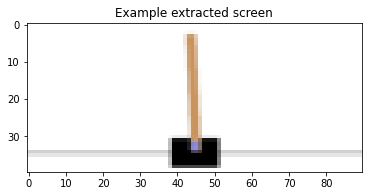

In [236]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render().transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    if cart_location < view_width // 2:
        slice_range = slice(view_width)
    elif cart_location > (screen_width - view_width // 2):
        slice_range = slice(-view_width, None)
    else:
        slice_range = slice(cart_location - view_width // 2,
                            cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [240]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayBuffer(3000)

steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

episode_durations = []

def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if is_ipython:
        display.display(plt.gcf())
        display.clear_output(wait=True)

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

In [241]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

Complete


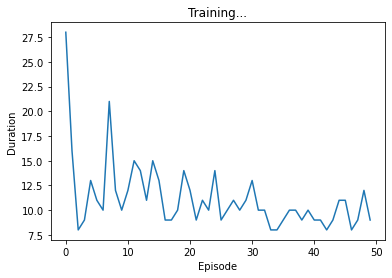

In [242]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        # Observe new state
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            next_state = current_screen - last_screen
        else:
            next_state = None
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        # Move to the next state
        state = next_state
        # Perform one step of the optimization (on the policy network)
        # optimize_model()
        if done:
            episode_durations.append(t + 1)
            if num_episodes == 50:
                plot_durations()
            break
        # Update the target network, copying all weights and biases in DQN
        if t % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

print('Complete')
env.render()
env.close()
plt.show()